In [1]:
# Import modules

#import wget
import constants as const 
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
import statistics
import seaborn as sns

In [2]:
# Download dataset and load it as a Pandas DataFrame

#wget.download(https://opendata-renewables.engie.com//media/datasets/d543716b-368d-4c53-8fb1-55addbe8d3ad.zip)
#wget.download(https://opendata-renewables.engie.com//media/datasets/01c55756-5cd6-4f60-9f63-2d771bb25a1a.zip)

data_turbines1 = pd.read_csv('../Dataset/la-haute-borne-data-2013-2016.csv',sep=';')
data_turbines2 = pd.read_csv('../Dataset/la-haute-borne-data-2017-2020.csv',sep=';')
raw_dataset = pd.concat([data_turbines1,data_turbines2])

print(data_turbines1.shape)
print(data_turbines2.shape)
print(raw_dataset.shape)

(840380, 138)
(217588, 138)
(1057968, 138)


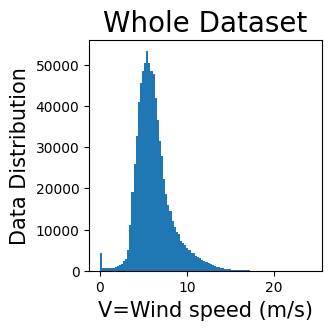

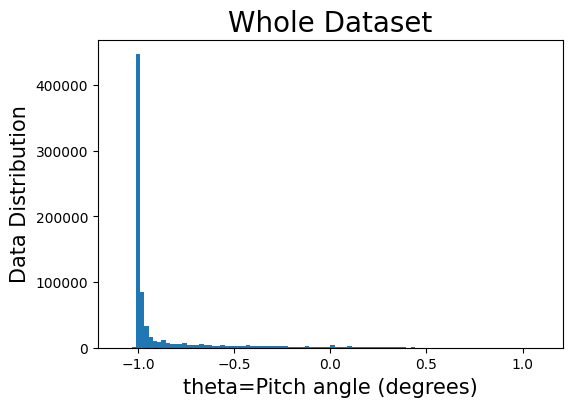

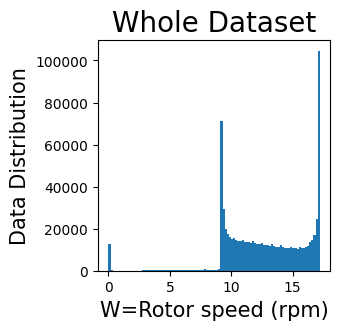

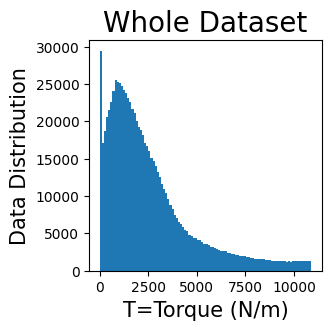

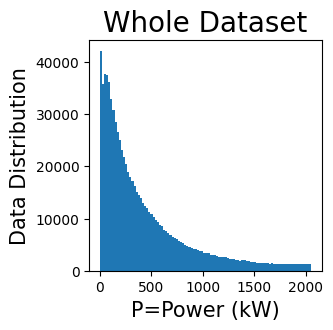

(816689, 6)


In [3]:
# Visualize data

from numpy import float64

data_turbines = raw_dataset.copy()

# Extract the desired variables
data_turbines = data_turbines[['Wind_turbine_name','Ws_avg','Ba_avg','Rs_avg','Rm_avg','P_avg']]

# Drop out all rows with NaN values
data_turbines = data_turbines.dropna()
data_turbines = data_turbines.dropna(axis=0)

# Remove data with negative torque, wind speed, rotor angular speed, or active power
data_turbines = data_turbines[ (data_turbines['Rm_avg'] >= 0.0) ]
data_turbines = data_turbines[ (data_turbines['Ws_avg'] >= 0.0) ]
data_turbines = data_turbines[ (data_turbines['Rs_avg'] >= 0.0) ]
data_turbines = data_turbines[ (data_turbines['P_avg'] >= 0.0) ]
#data_turbines['P_avg'] = data_turbines['P_avg'].apply(lambda x: 0.0 if x <= 20 else x)

# Remove data with pitch angle > 0 
#data_turbines = data_turbines[ (data_turbines['Ba_avg'] < 0.0) ]

# Define inputs and outputs
X_data = data_turbines[['Ws_avg','Ba_avg','Rs_avg']]
Y_data = data_turbines[['Rm_avg','P_avg']]
name_data = data_turbines['Wind_turbine_name']

# Convert data to numpy arrays
X_data = X_data.to_numpy(dtype='float64')
Y_data = Y_data.to_numpy(dtype='float64')
#print(X_data.shape)
#print(Y_data.shape)

# Distribution of the variables

plt.figure(figsize=(3,3))
plt.hist(X_data[:,0], bins=100)
plt.xlabel('V=Wind speed (m/s)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(X_data[:,1], range=[-1.1, 1.1],bins=100)
plt.xlabel('theta=Pitch angle (degrees)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

plt.figure(figsize=(3,3))
plt.hist(X_data[:,2], bins=100)
plt.xlabel('W=Rotor speed (rpm)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

plt.figure(figsize=(3,3))
plt.hist(Y_data[:,0], bins=100)
plt.xlabel('T=Torque (N/m)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

plt.figure(figsize=(3,3))
plt.hist(Y_data[:,1], bins=100)
plt.xlabel('P=Power (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

print(data_turbines.shape)

# Convert inputs to desired units
X_data[:,1] = X_data[:,1] * np.pi / 180.0   # pitch angle from degrees to rad
X_data[:,2] = X_data[:,2] * 2*np.pi / 60.0  # rotor speed from rpm to rad/s
Y_data[:,1] = Y_data[:,1] * 1000.0          # power from kW to W


/tmp/ipykernel_20045/65577642.py:5: RuntimeWarning: divide by zero encountered in divide
  Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)
/tmp/ipykernel_20045/65577642.py:5: RuntimeWarning: invalid value encountered in divide
  Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)
/tmp/ipykernel_20045/65577642.py:19: RuntimeWarning: divide by zero encountered in divide
  lambd = Wwt * const.R / Vw
/tmp/ipykernel_20045/65577642.py:19: RuntimeWarning: invalid value encountered in divide
  lambd = Wwt * const.R / Vw


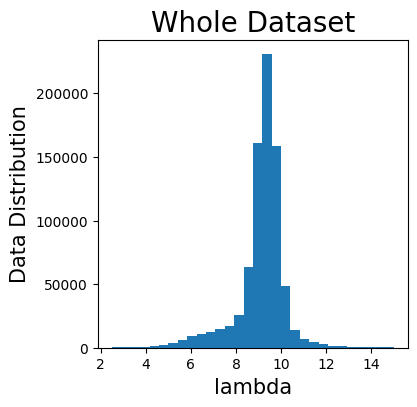

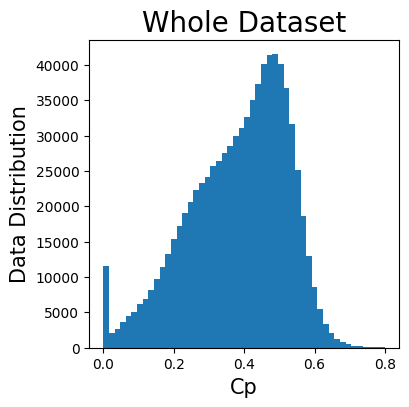

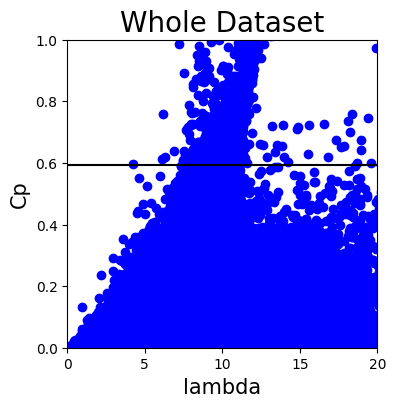

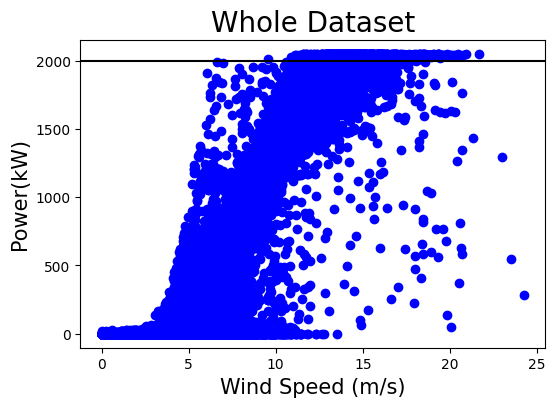

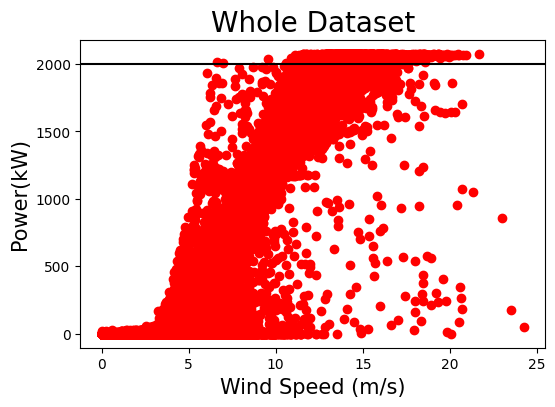

P(data) and P(from T) difference: nan %
nan


/tmp/ipykernel_20045/65577642.py:80: RuntimeWarning: divide by zero encountered in divide
  P_diff = (Y_data[:,1] - Power_fromT(Y_data[:,0], X_data[:,2])) / Y_data[:,1]
/tmp/ipykernel_20045/65577642.py:80: RuntimeWarning: invalid value encountered in divide
  P_diff = (Y_data[:,1] - Power_fromT(Y_data[:,0], X_data[:,2])) / Y_data[:,1]


In [4]:
# Check Cp for the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def Cp_fromT(Tgen, Vw, Wwt):

    Tt = Tgen * const.gear
    Pturbina = Tt* Wwt
    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp    

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

def Power_fromT( Tgen, Wwt):

    Pturbina = const.gear * Tgen * Wwt
    return Pturbina

Cp_data = np.zeros(len(Y_data[:,0]))
lambd_data = np.zeros(len(Y_data[:,0]))
Cp_data[:] = Cp_fromP(Y_data[:,1], X_data[:,0])
lambd_data[:] = lambd(X_data[:,0], X_data[:,2])

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of Cp
plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Plot Cp vs lambda
plt.figure(figsize=(4,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_data, Cp_data, 'bo')
plt.axhline(y=0.5926, color = 'k', linestyle = '-')
plt.xlim([0,20])
plt.ylim([0,1])
plt.show()

# Plot P vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power(kW)',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(X_data[:,0], Y_data[:,1]/1000, 'bo')
plt.axhline(y=2000, color = 'k', linestyle = '-')
plt.show()

# Plot P(from T) vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power(kW)',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(X_data[:,0], Power_fromT(Y_data[:,0], X_data[:,2])/1000, 'ro')
plt.axhline(y=2000, color = 'k', linestyle = '-')
plt.show()

# Differences between P(data) and P(from T)
P_diff = np.zeros(len(Y_data[:,1]))
P_diff = (Y_data[:,1] - Power_fromT(Y_data[:,0], X_data[:,2])) / Y_data[:,1]
P_diff = abs(P_diff) * 100
print('P(data) and P(from T) difference: ' + str(np.mean(P_diff)) + ' %')
print(median_abs_deviation(P_diff))


P_all = Y_data[:,1]
V_all = X_data[:,0]

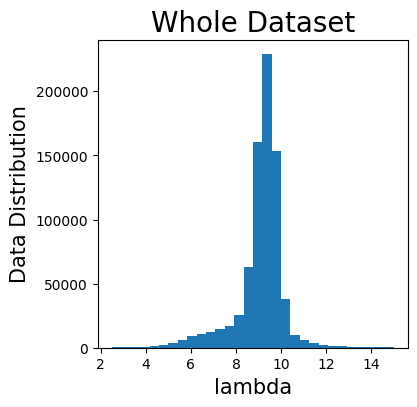

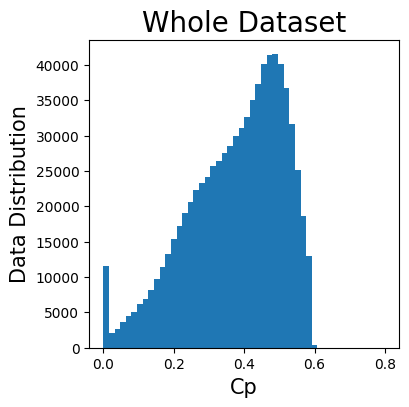

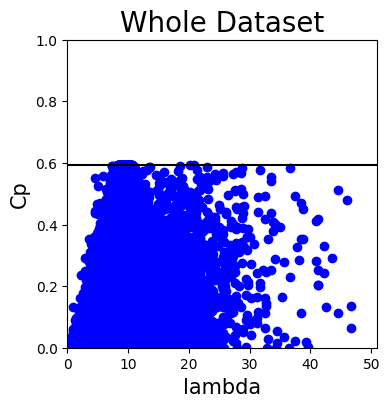

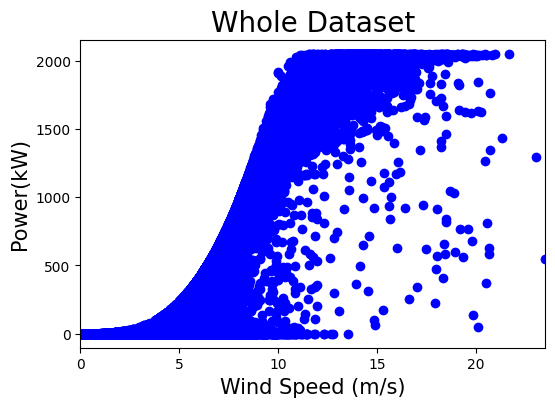

(789831, 3)


In [5]:
# Remove data with Cp>0.5926
Cp_max = 0.5926
X_data = X_data [ (Cp_data < Cp_max) ]
name_data = name_data [ (Cp_data < Cp_max) ]
Y_data = Y_data [ (Cp_data < Cp_max) ]
lambd_data = lambd_data [ (Cp_data < Cp_max) ]
Cp_data = Cp_data [ (Cp_data < Cp_max) ]
#print(Cp_data [ (Cp_data > Cp_max) ]) # empty list. The plot looks like Cp_data > Cp_max
                                       # because of the size of the blue circles


# Revome data with theta outside [theta_min,theta_max]
""" theta_min = -1.05 *np.pi/180
theta_max = -0.8 *np.pi/180
name_data = name_data [ (X_data[:,1] > theta_min) & (X_data[:,1] < theta_max) ]
Y_data = Y_data [ (X_data[:,1] > theta_min) & (X_data[:,1] < theta_max) ]
Cp_data = Cp_data [ (X_data[:,1] > theta_min) & (X_data[:,1] < theta_max) ]
lambd_data = lambd_data [ (X_data[:,1] > theta_min) & (X_data[:,1] < theta_max) ]
X_data = X_data [ (X_data[:,1] > theta_min) & (X_data[:,1] < theta_max) ] """


# Revome data with lambd outside [0,22]
lmin = 0
lmax = 50
"""
X_data = X_data [ (lmin<lambd_data) & (lambd_data<lmax) ]
name_data = name_data [ (lmin<lambd_data) & (lambd_data<lmax) ]
Y_data = Y_data [ (lmin<lambd_data) & (lambd_data<lmax) ]
Cp_data = Cp_data [ (lmin<lambd_data) & (lambd_data<lmax) ]
lambd_data = lambd_data [ (lmin<lambd_data) & (lambd_data<lmax) ] """

# Revome data with Vw>22 
vmin = 0
vmax = 22.5
""" Y_data = Y_data [ (X_data[:,0] < vmax) ]
lambd_data = lambd_data [ (X_data[:,0] < vmax) ]
Cp_data = Cp_data [ (X_data[:,0] < vmax) ]
name_data = name_data [ (X_data[:,0] < vmax) ]
X_data = X_data [ (X_data[:,0] < vmax) ] """

# Remove data with P>2050 kW
""" P_max = 2050
X_data = X_data [ (Y_data[:,1]/1000 < P_max) ]
name_data = name_data [ (Y_data[:,1]/1000 < P_max) ]
lambd_data = lambd_data [ (Y_data[:,1]/1000 < P_max) ]
Cp_data = Cp_data [ (Y_data[:,1]/1000 < P_max) ]
Y_data = Y_data [ (Y_data[:,1]/1000 < P_max) ] """

# Remove data with rotor speed outside [8.5,17.1] rpm
""" wmin = 8.5              # rpm
wmax = 17.1             # rpm
wmin = wmin*2*np.pi/60  # rad/s
wmax = wmax*2*np.pi/60  # rad/s
name_data = name_data [ (wmin<X_data[:,2]) & (X_data[:,2]<wmax) ]
Y_data = Y_data [ (wmin<X_data[:,2]) & (X_data[:,2]<wmax) ]
Cp_data = Cp_data [ (wmin<X_data[:,2]) & (X_data[:,2]<wmax) ]
lambd_data = lambd_data [ (wmin<X_data[:,2]) & (X_data[:,2]<wmax) ]
X_data = X_data [ (wmin<X_data[:,2]) & (X_data[:,2]<wmax) ] """


# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of Cp
plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Plot Cp vs lambda
plt.figure(figsize=(4,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_data, Cp_data, 'bo')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([0,lmax+1])
plt.ylim([0,1])
plt.show()

# Plot P vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power(kW)',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(X_data[:,0], Y_data[:,1]/1000, 'bo')
plt.xlim([0,vmax+1])
#plt.ylim([0,100])
plt.show()

print(X_data.shape)

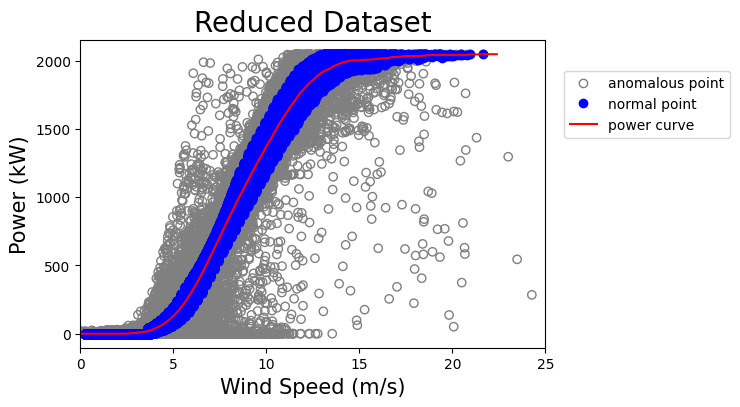

(727292,)


In [7]:
# Discard anomalous data from power curve

# Estimate the power curve with an iterative median estimation technique. 
nbins = 100
P_estimated = np.zeros(nbins)
V_estimated = np.zeros(nbins)
dv = (vmax-vmin)/nbins

P_estimated[0]=0.0
for i in range(1,nbins):
    vl = vmin + i*dv
    vr = vl + dv

    # Median of P in the bin i
    V_estimated[i] = (vl+vr)/2.0
    v_subset = (vl<X_data[:,0]) & (X_data[:,0]<vr)  # subset of v points of the bin
    #Pi = Y_data[:,1][(vl<X_data[:,0]) & (X_data[:,0]<vr)]
    Pi = Y_data[:,1][v_subset]                      # Power distribution of bin i
    if (len(Pi)>0):
        P_estimated[i]=statistics.median(Pi)
        #P_estimated[i]=statistics.mean(Pi)
    else:
        P_estimated[i]=P_estimated[i-1]

    if(V_estimated[i]>=15 and P_estimated[i]-P_estimated[i-1]<0):
        P_estimated[i] = P_estimated[i-1]
        


#Each point is removed if it is further than 3*sigma from the median at each bin
name_good = []
P_good = []
V_good = []
W_good = []
theta_good = []
T_good = []
for i in range(1,nbins):
    vl = vmin + i*dv
    vr = vl + dv

    if(P_estimated[i]>=0.0):
        v_subset = (vl<X_data[:,0]) & (X_data[:,0]<vr)
        Pi = Y_data[:,1][v_subset]              # power distribution of bin i
        sigma = median_abs_deviation(Pi)
        p_condition = (np.abs(Y_data[:,1]-P_estimated[i]) < 3*sigma )

        if(vl<3.5): 
        
            # sigma is too small because data are very close to zero,
            # so we remove points farther than 100 kW and having a Cp>0.001
            # We impose the Cp condition to avoid noisy points with a high Cp value
            Pgap = 25 * 1000 
            p_condition1 = (Y_data[:,1] < Pgap )
            p_condition2 = ( Cp_fromP(Y_data[:,1], X_data[:,0]) < 0.001 )
            p_condition = p_condition1 & p_condition2

        if(vl>18.5): 
            # sigma is too big because there are no much data,
            # so we remove points farther than 200 kW
            Pgap = 200 * 1000
            p_condition = (np.abs(Y_data[:,1]-P_estimated[i]) < Pgap )

        P_good = np.append(P_good, Y_data[:,1][v_subset & p_condition])
        V_good = np.append(V_good, X_data[:,0][v_subset & p_condition])

        W_good = np.append(W_good, X_data[:,2][v_subset & p_condition])
        theta_good = np.append(theta_good, X_data[:,1][v_subset & p_condition])
        T_good = np.append(T_good, Y_data[:,0][v_subset & p_condition]) 

        name_good = np.append(name_good, name_data[:][v_subset & p_condition]) 

V_good = np.array(V_good[:],dtype='float64')
theta_good = np.array(theta_good[:],dtype='float64')
W_good = np.array(W_good[:],dtype='float64')
T_good = np.array(T_good[:],dtype='float64')
P_good = np.array(P_good[:],dtype='float64')

# Power curve from manufacturer
#V_manu = np.arange(3.5,22.5,0.5)
#P_manu = np.zeros(38)
#P_manu = [25,66,129,192,267,343,431,519,615,711,835,959,1157,1355,1518,1681,1771,1861,
#1904,1947,1970,1987,1996,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,
#2000, 2000, 2000]
#for i in range(38):
#    print(str(V_manu[i])+" "+str(P_manu[i]))

# Plot P vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power (kW)',fontsize=15)
plt.title('Reduced Dataset',fontsize=20)
plt.scatter(V_all, P_all/1000,facecolors='none',edgecolors='grey', label='anomalous point')
plt.plot(V_good, P_good/1000,'bo',label='normal point')
plt.plot(V_estimated, P_estimated/1000, 'r-',label='power curve')
#plt.plot(V_manu, P_manu, 'k-',label='manufacturer power curve')
#plt.xlim([1,17])
plt.xlim([0,25])
#plt.ylim([0,100])
l1 = plt.legend(bbox_to_anchor=(1.04, 0.9), borderaxespad=0)
plt.show()

print(P_good.shape)


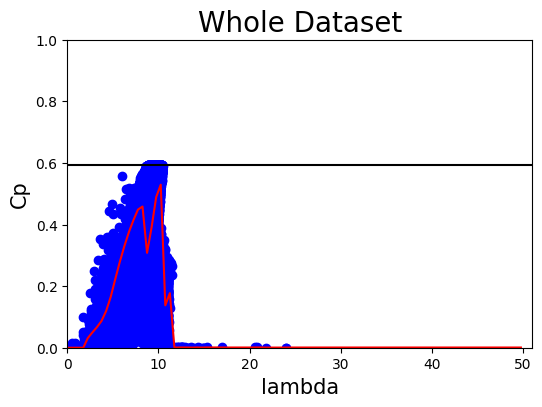

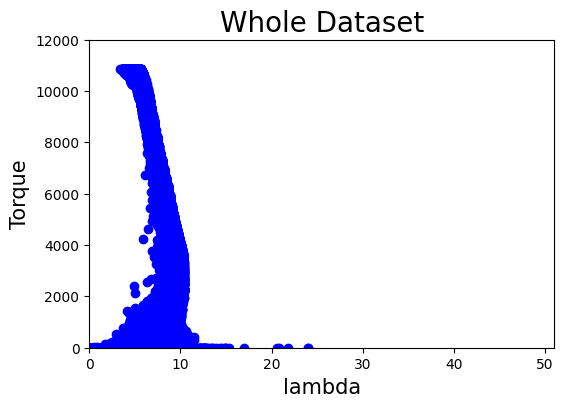

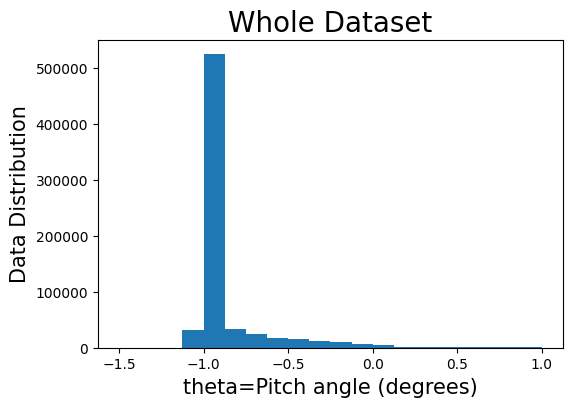

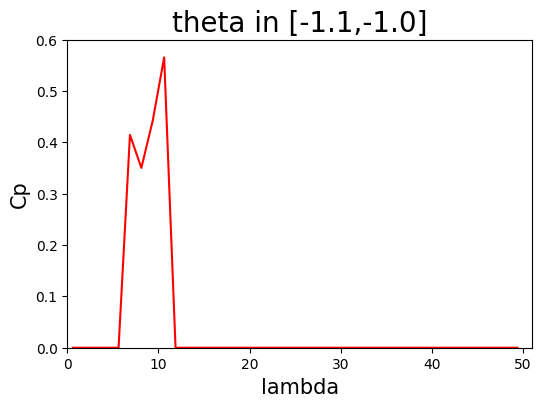

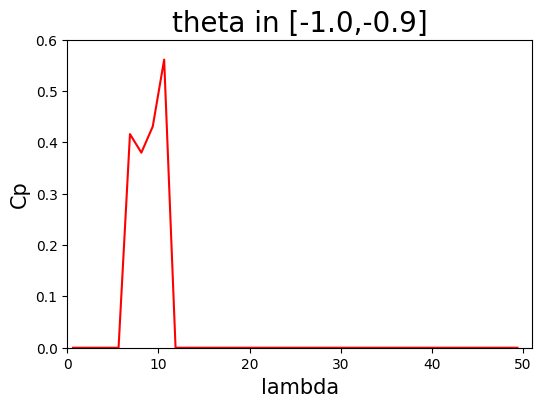

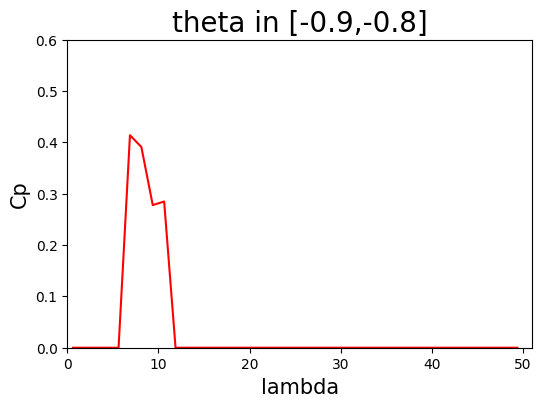

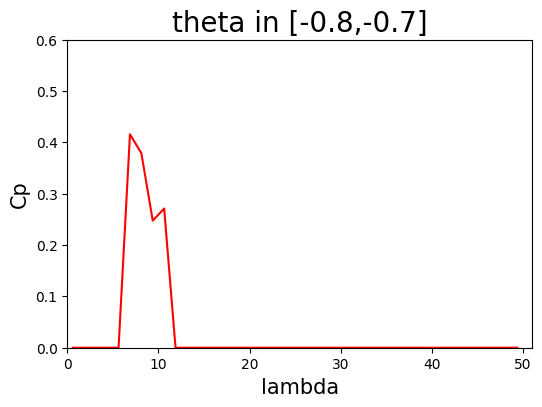

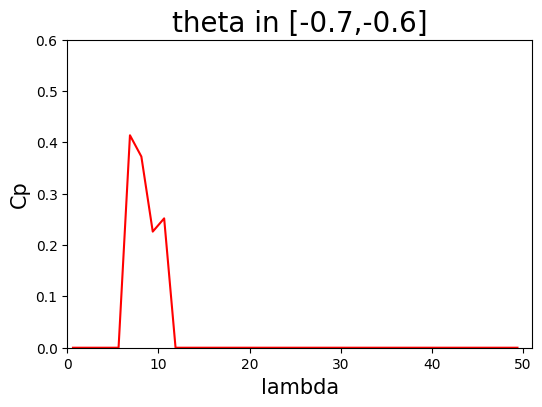

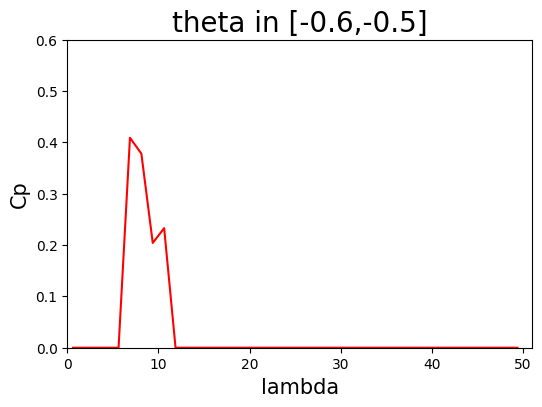

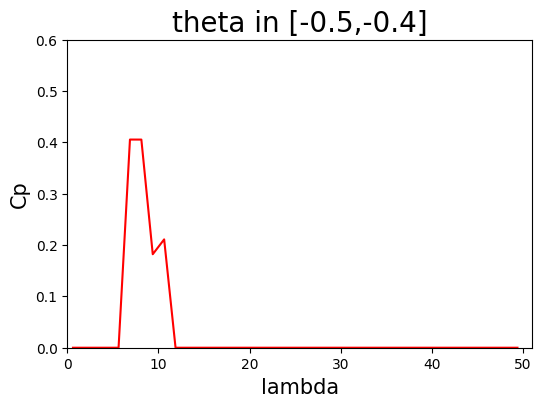

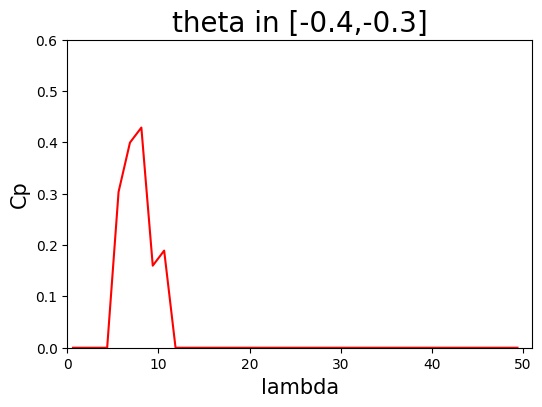

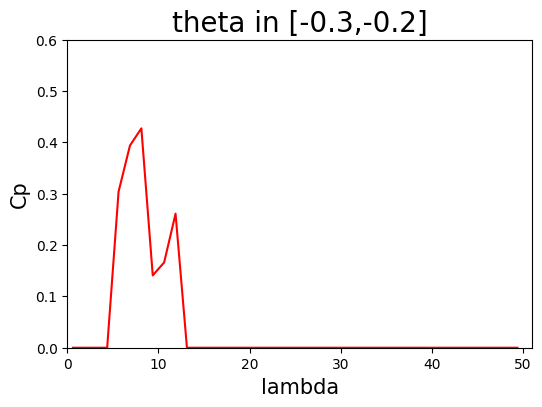

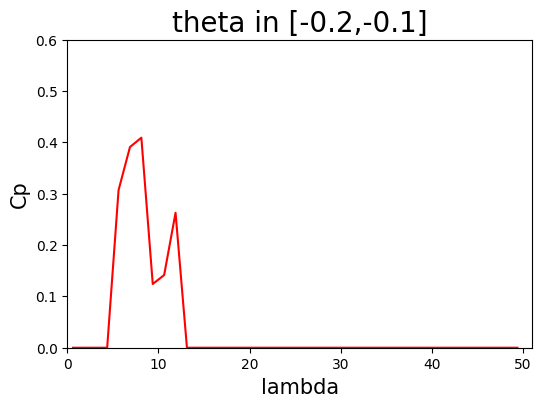

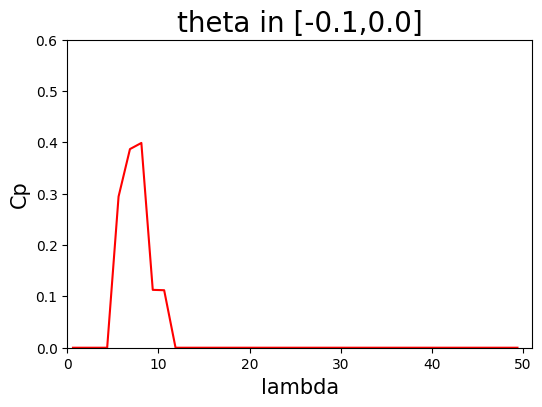

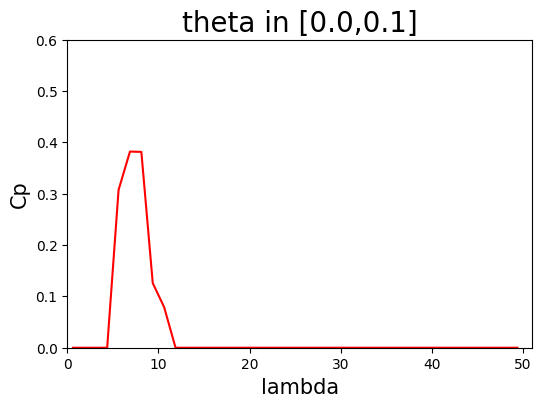

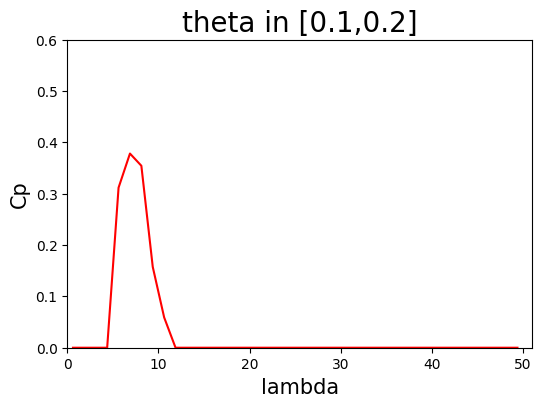

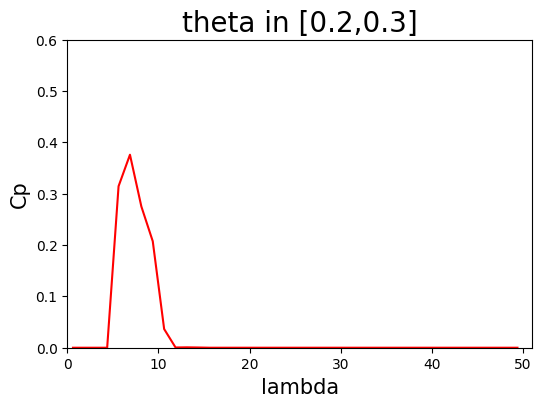

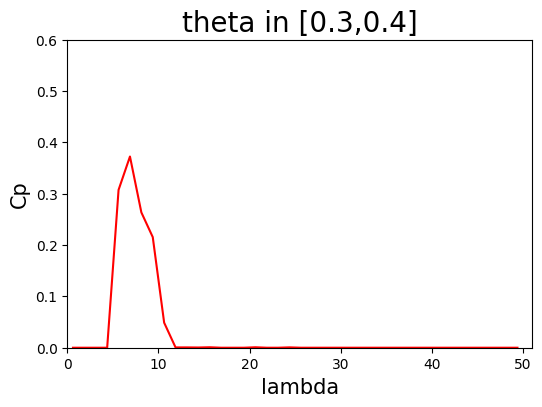

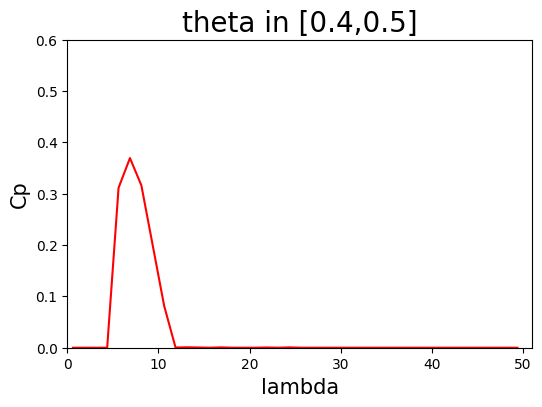

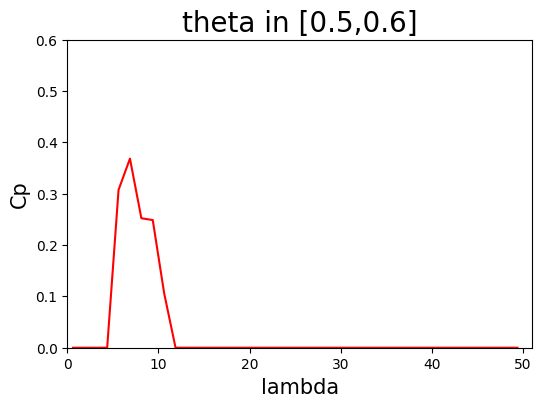

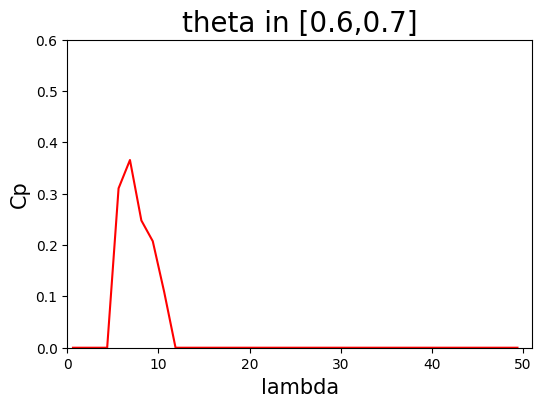

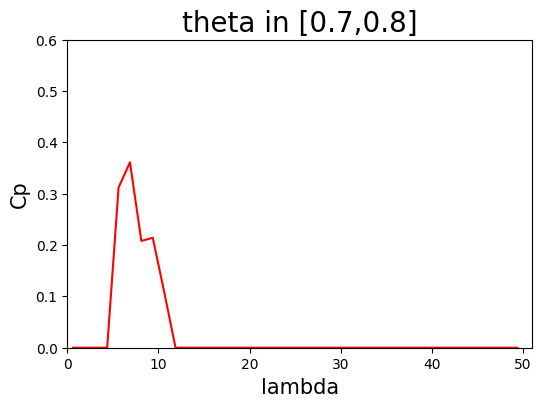

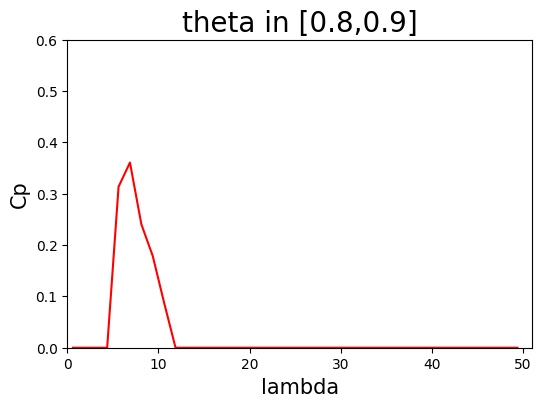

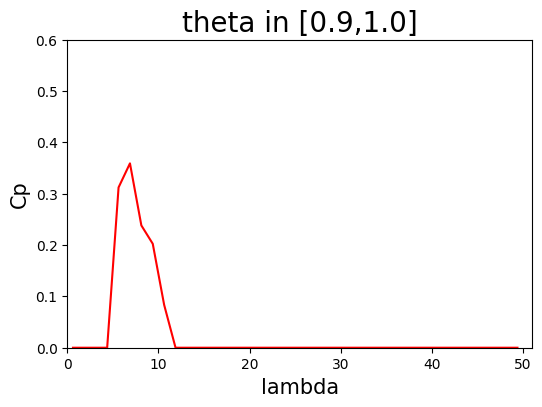

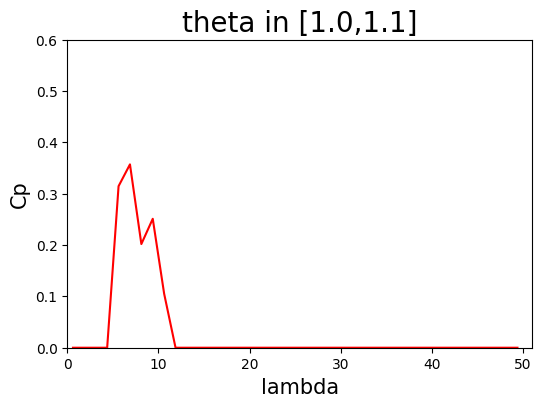

In [8]:
# Cp curve
Cp_good = np.zeros(len(P_good))
lambd_good = np.zeros(len(P_good))
Cp_good = Cp_fromP(P_good, V_good)
lambd_good = lambd(V_good, W_good)

# Estimate the Cp curve with an iterative median estimation technique. 
nbins = 100
Cp_estimated = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

Cp_estimated[0]=0.0
for i in range(1,nbins):
    lambdal = lmin + i*dl
    lambdar = lambdal + dl

    # Median of Cp in the bin i
    lambd_estimated[i] = (lambdal+lambdar)/2.0
    l_subset = (lambdal<lambd_good) & (lambd_good<lambdar)  # subset of lambda points of the bin
    Cpi = Cp_good[l_subset]     # Cp distribution of bin i
    if (len(Cpi)>0):
        Cp_estimated[i]=statistics.median(Cpi)
    else:
        Cp_estimated[i]=Cp_estimated[i-1]

# Ideal Betz limit curve for multiblade turbines
#Cp_limit = np.zeros(21)
#lambd_limit = np.arange(0,10.5,0.5)
#Cp_limit = [0, 0.238, 0.4, 0.475, 0.515, 0.531, 0.537, 0.538, 0.541, 0.544, 
#0.547, 0.550, 0.553, 0.556, 0.559, 0.562, 0.565,  0.568, 0.570, 0.572, 0.574]

# Plot Cp vs lambda (independently of the theta angle)
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_good, Cp_good, 'bo')
plt.plot(lambd_estimated, Cp_estimated, 'r-')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
#plt.plot(lambd_limit, Cp_limit, 'k-')
plt.xlim([0,lmax+1])
plt.ylim([0,1])
plt.show()

# Plot of Torque vs lambda (independently of the theta angle)

plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Torque',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_good, T_good, 'bo')
#plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
#plt.plot(lambd_limit, Cp_limit, 'k-')
plt.xlim([0,lmax+1])
plt.ylim([0,12000])
plt.show()


# Histogram of theta
plt.figure(figsize=(6,4))
plt.hist(theta_good*180/np.pi, range=[-1.5, 1],bins=20)
plt.xlabel('theta=Pitch angle (degrees)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Cp(lambd,theta)

# lambda binning
nbins = 40
#lmin = 2
#lmax = 22
Cp_estimated = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

# theta binning
theta_min = -1.1 *np.pi/180.0        # (degree to rad)
theta_max = 1.1  *np.pi/180.0
nangles = 22
da = (theta_max - theta_min) / nangles

for i in range(nangles):
    angle_l = theta_min + i*da
    angle_h = angle_l + da
    angle = (angle_l + angle_h)/2

    cond_angle = (angle_l<theta_good) & (theta_good<angle_h)
    theta_prov = theta_good[ cond_angle ]
    lambd_prov = lambd_good[ cond_angle ]
    Cp_prov = Cp_good[ cond_angle ]

    Cp_estimated[0]=0.0
    for j in range(nbins):
        lambdal = lmin + j*dl
        lambdar = lambdal + dl

        # Median of Cp in the bin j
        lambd_estimated[j] = (lambdal+lambdar)/2.0
        l_subset = (lambdal<lambd_prov) & (lambd_prov<lambdar)  # subset of lambda points of the bin
        Cpj = Cp_prov[l_subset]     # Cp distribution of bin j
        if (len(Cpj)>0):
            Cp_estimated[j]=statistics.mean(Cpj)
        else:
            Cp_estimated[j]=0.0

    plt.figure(figsize=(6,4))
    plt.xlabel('lambda',fontsize=15)
    plt.ylabel('Cp',fontsize=15)
    plt.plot(lambd_estimated, Cp_estimated, 'r-')
    #plt.title('theta='+str( round(angle*180/np.pi,2) ),fontsize=20)
    plt.title('theta in ['+str( round(angle_l*180/np.pi,2) )+','+str( round(angle_h*180/np.pi,2) )+']',fontsize=20)
    plt.xlim([0,lmax+1])
    plt.ylim([0,0.6])
    plt.show()


In [9]:
# Differences between P(data) and P(from T)
P_diff = np.zeros(len(P_good[:]))
P_diff_abs = np.abs(P_good[:] - Power_fromT(T_good[:], W_good[:]))
print(np.mean(P_diff_abs)) # in Wats
print(median_abs_deviation(P_diff_abs))
print(np.mean(P_diff_abs)/1000) # in kWats
print(median_abs_deviation(P_diff_abs)/1000)

print()
P_diff_abs = np.zeros(len(P_good[:]))
n_elements = 0
for i in range(len(P_good)):
    if(P_good[i]>0.0):
        P_diff_abs[i] = ( np.abs(P_good[i] - Power_fromT(T_good[i], W_good[i])) ) / P_good[i] * 100
        n_elements = n_elements+1

print(np.sum(P_diff_abs)/n_elements) # in %

4704.192120370702
1818.7469475331382
4.704192120370702
1.8187469475331381

1.6846911724787834


In [9]:
# Finally, save dataset in Wats, rads/s and rads for power, angular velocity and angle

data = zip(name_data, V_good, theta_good, W_good, T_good, P_good)

import csv
header = ['turbine', 'V', 'theta', 'W', 'T', 'P']
with open('../Dataset/Dataset_reduced.csv','w',encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header 
    writer.writerow(header)

    # write multiple rows
    writer.writerows(data)

/tmp/ipykernel_18670/3556091963.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(V_good)


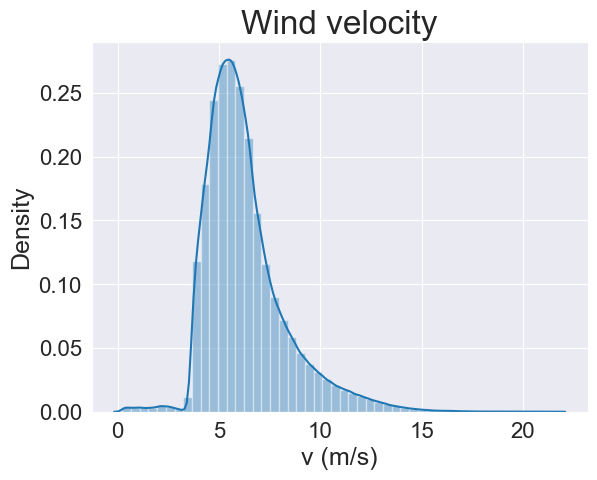

/tmp/ipykernel_18670/3556091963.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(theta_good)


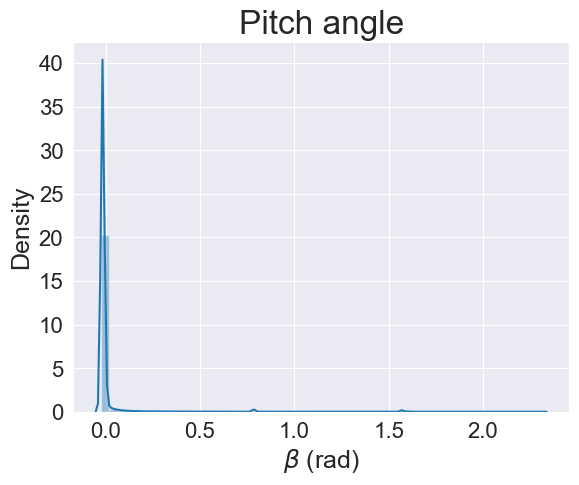

/tmp/ipykernel_18670/3556091963.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(W_good)


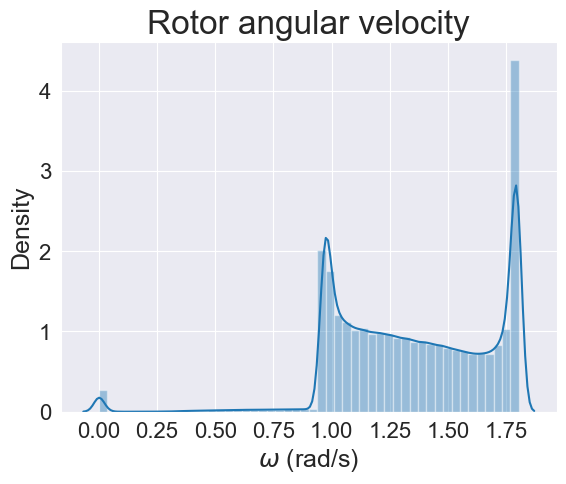

/tmp/ipykernel_18670/3556091963.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(P_good/1000)


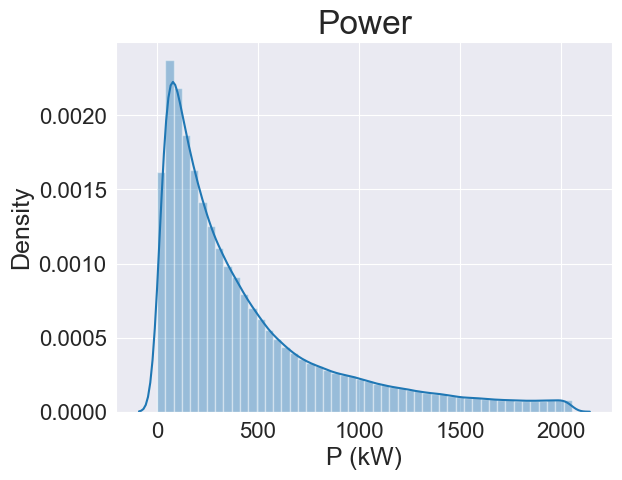

/tmp/ipykernel_18670/3556091963.py:42: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T_good)


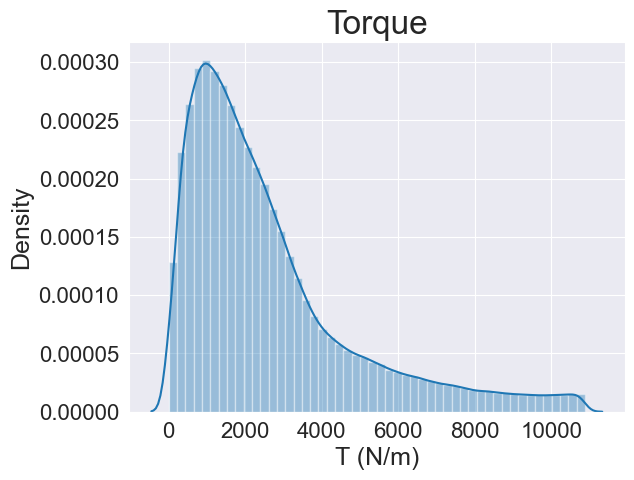

/tmp/ipykernel_18670/3556091963.py:51: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Cp_good)


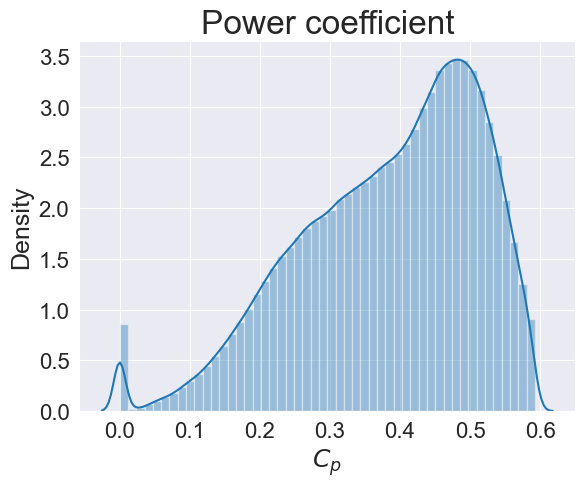

In [29]:
# Data distribution

sns.set_style('darkgrid')
sns.distplot(V_good)
plt.xlabel('v (m/s)',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Wind velocity',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

sns.set_style('darkgrid')
sns.distplot(theta_good)
plt.xlabel(r'$\beta$ (rad)',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Pitch angle',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlim([-0.1,0.1])
plt.show()

sns.set_style('darkgrid')
sns.distplot(W_good)
plt.xlabel(r'$\omega$ (rad/s)',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Rotor angular velocity',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlim([-0.1,0.1])
plt.show()

sns.set_style('darkgrid')
sns.distplot(P_good/1000)
plt.title('Power',fontsize=24)
plt.xlabel('P (kW)',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

sns.set_style('darkgrid')
sns.distplot(T_good)
plt.xlabel('T (N/m)',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Torque',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

sns.set_style('darkgrid')
sns.distplot(Cp_good)
plt.xlabel(r'$C_p$',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Power coefficient',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


In [10]:
print(raw_dataset.shape)
print(P_good.shape)

(1057968, 138)
(727292,)


In [34]:
from PIL import Image


def combine_images(columns, space, images):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
    background.save('../Figures/Var_distribution.png')


#combine_images(columns=3, space=20, images=['apple_PNG12507.png', 'banana_PNG838.png', 'blackberry_PNG45.png', 'cherry_PNG635.png', 'pear_PNG3466.png', 'plum_PNG8670.png', 'strawberry_PNG2595.png'])
combine_images(columns=3, space=20, images=['../Figures/V.png','../Figures/theta.png','../Figures/W.png','../Figures/Torque.png','../Figures/Power.png','../Figures/Cp.png'])